In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from crypto_prediction.data.fetch_data import fetch_data

2023-02-22 20:28:13.662787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = fetch_data('BTC-USD')[2:]
df = pd.DataFrame(df[['fng_idx','close']])
df.head()

[*********************100%***********************]  1 of 1 completed


,fng_idx,close
timestamp,,
2023-02-20,58.0,24829.148438
2023-02-19,60.0,24327.642578
2023-02-18,60.0,24641.277344
2023-02-17,61.0,24565.601562
2023-02-16,62.0,23623.474609


In [4]:
mm_scaler = MinMaxScaler()
df_scaled = mm_scaler.fit_transform(df)
df_scaled

array([[0.58888889, 0.33565   ],
       [0.61111111, 0.32785418],
       [0.61111111, 0.33272957],
       ...,
       [0.38888889, 0.09230751],
       [0.11111111, 0.0869576 ],
       [0.27777778, 0.09223958]])

In [5]:
period = 20
def split_dataset(df, period):
    X = list()
    y = list()
    
    for i in range(len(df) - period - 1):
        X.append(df[i:(i + period), :])
        y.append(df[i + period, 1])
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y
        
X_train, y_train = split_dataset(df_scaled, period)

In [6]:
X_train.shape

(1825, 20, 2)

In [7]:
X_train[0]

array([[0.58888889, 0.33565   ],
       [0.61111111, 0.32785418],
       [0.61111111, 0.33272957],
       [0.62222222, 0.33155321],
       [0.63333333, 0.316908  ],
       [0.53333333, 0.32754638],
       [0.5       , 0.29510374],
       [0.47777778, 0.28868834],
       [0.5       , 0.28837902],
       [0.48888889, 0.28966414],
       [0.47777778, 0.28624907],
       [0.55555556, 0.28885836],
       [0.58888889, 0.30627415],
       [0.54444444, 0.31132455],
       [0.56666667, 0.30348714],
       [0.58888889, 0.30652703],
       [0.58888889, 0.31237471],
       [0.61111111, 0.31420083],
       [0.61111111, 0.31455135],
       [0.56666667, 0.31846707]])

In [8]:
y_train.shape

(1825,)

## Modeling

In [9]:
model = Sequential()

model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


2023-02-22 20:28:23.990202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 100)           41200     
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(
    X_train, y_train,
    #callbacks=[es],
    validation_split=0.2,
    epochs=20,
    batch_size=12,
    verbose=1
)

Epoch 1/20
122/122 [==============================] - 6s 18ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 2/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0037 - val_loss: 9.8737e-05
Epoch 3/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0027 - val_loss: 1.7710e-04
Epoch 4/20
122/122 [==============================] - 2s 14ms/step - loss: 0.0023 - val_loss: 1.1054e-04
Epoch 5/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 1.0447e-04
Epoch 6/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0020 - val_loss: 9.2014e-05
Epoch 7/20
122/122 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 8.8545e-05
Epoch 8/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0019 - val_loss: 3.0065e-04
Epoch 9/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0018 - val_loss: 1.2687e-04
Epoch 10/20
122/122 [==============================] - 2s 1

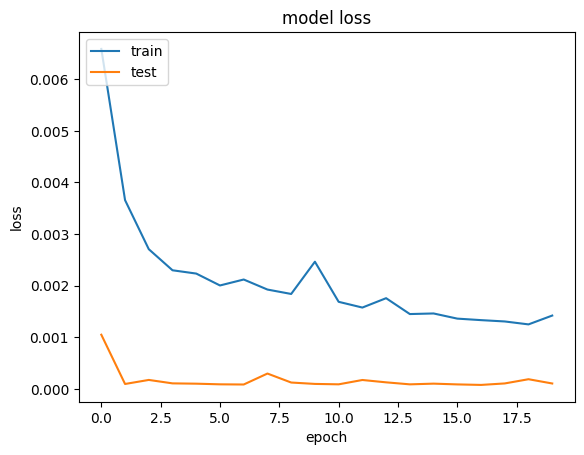

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
X_test = df.iloc[:,:].values
X_test.shape

(1846, 2)

In [13]:
y_real = df.iloc[period+1:,1].values
y_real.shape

(1825,)

In [14]:
X_test = mm_scaler.transform(X_test)
X_test, y_test = split_dataset(X_test, period)

/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [15]:
X_test.shape

(1825, 20, 2)

In [18]:
y_test.shape

(1825,)

In [16]:
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
# X_test.shape

In [23]:
y_pred = model.predict(X_test)
y_pred

58/58 [==============================] - 0s 6ms/step


array([[0.32485926],
       [0.31778747],
       [0.32091355],
       ...,
       [0.03892462],
       [0.04644471],
       [0.07273875]], dtype=float32)

In [29]:
mm_scaler.min_, mm_scaler.scale_, mm_scaler.data_min_, mm_scaler.data_max_

(array([-0.05555556, -0.05031491]),
 array([1.11111111e-02, 1.55448308e-05]),
 array([   5.        , 3236.76171875]),
 array([   95.      , 67566.828125]))

In [38]:
mm_scaler_pred = MinMaxScaler()
mm_scaler_pred.min_, mm_scaler_pred.scale_ = mm_scaler.min_[1], mm_scaler.scale_[1]

**when rescaling the prediction scaler needs the same format when it was fitted. But we can transfer attributes from general scaler to a more specific scaler of our 'close' column**

In [42]:
prediction = mm_scaler_pred.inverse_transform(y_pred)
prediction.shape

(1825, 1)

In [40]:
prediction

array([[24134.979 ],
       [23680.05  ],
       [23881.152 ],
       ...,
       [ 5740.7856],
       [ 6224.5527],
       [ 7916.051 ]], dtype=float32)

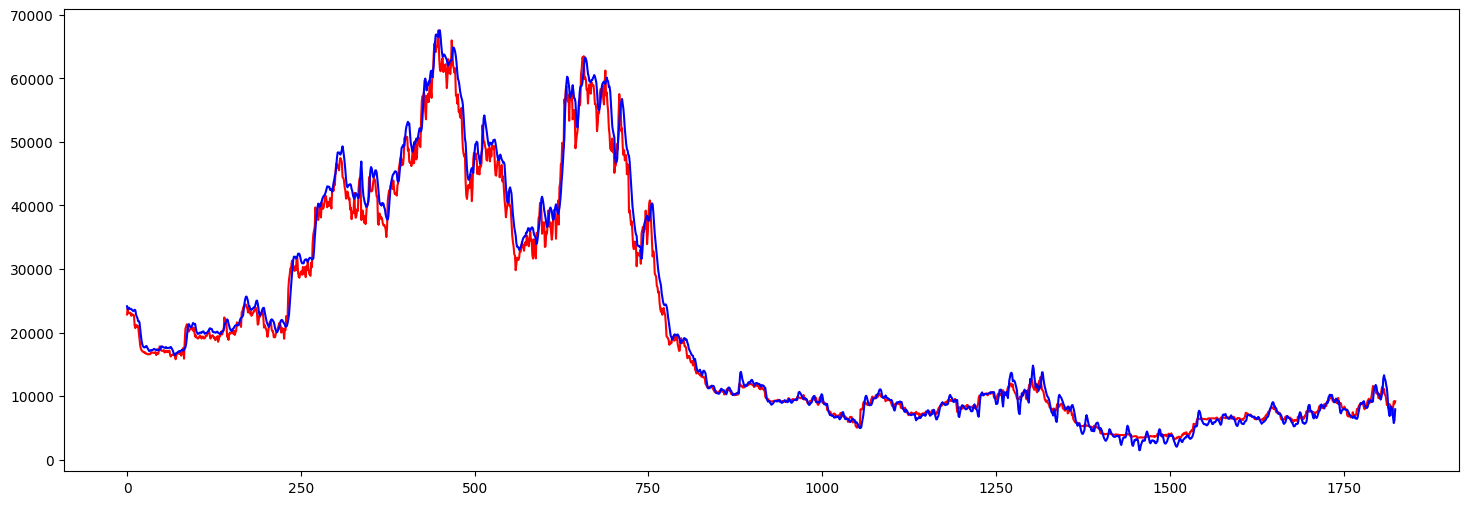

In [41]:
plt.figure(figsize=(18,6))
plt.plot(y_real, color='red', label='Real')
plt.plot(prediction, color='blue', label='Prediction')